### Trying to convert this old cold to intake catalog. 
### to improve the video for the AAPP comms manager

In [83]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors as col
import cmocean as cm
import numpy as np
import cf_xarray
import cmocean.cm as cmocean
import cartopy.crs as ccrs
import cartopy.feature as cft
import xarray as xr
import os

In [30]:
import intake

In [31]:
catalog = intake.cat.access_nri

In [32]:
catalog.search(model="ACCESS-OM2",  variable="temp", frequency = '1mon')

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55_ryf_ENFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 El Níño run for the simulations performed in Huguenin et al. (2024, GRL)}",{ocean},{1mon},{temp}
01deg_jra55_ryf_LNFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 La Níña run for the simulations performed in Huguenin et al. (2024, GRL)}",{ocean},{1mon},{temp}
01deg_jra55v13_ryf9091_qian_wthmp,{ACCESS-OM2},"{Future perturbations with wind, thermal and meltwater forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}",{ocean},{1mon},{temp}
01deg_jra55v13_ryf9091_qian_wthp,{ACCESS-OM2},"{Future perturbation with wind and thermal forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}",{ocean},{1mon},{temp}
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},{ocean},{1mon},{temp}
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},{ocean},{1mon},{temp}
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},{ocean},{1mon},{temp}
025deg_jra55_iaf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0\ninterannual forcing (1980-2019)},{ocean},{1mon},{temp}
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1mon},{temp}


In [57]:
experiment = "01deg_jra55v140_iaf_cycle3"
variable = "temp"
data_ic = catalog[experiment].search(
    variable=variable, 
    frequency="1mon"
).to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [34]:
data_ic["temp"]

<xarray.DataArray 'temp' (time: 732, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)> Size: 2TB
dask.array<concatenate, shape=(732, 75, 2700, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

In [35]:
depth_slice = 400
t_400=data_ic['temp'].cf.sel(st_ocean=depth_slice,method='nearest').cf.sel({'longitude': slice(-256, -240),'latitude': slice(-68, -63)}).load()


In [36]:
t_400=t_400 - 273.15

In [58]:
depth_slice = 1000
t_1000=data_ic['temp'].cf.sel(st_ocean=depth_slice,method='nearest').cf.sel({'longitude': slice(-256, -240),'latitude': slice(-68, -63)}).load()
t_1000=t_1000 - 273.15

### Load data to make the maps

In [37]:
catalog.search(model="ACCESS-OM2",  variable="ht")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55_ryf_ENFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 El Níño run for the simulations performed in Huguenin et al. (2024, GRL)}",{ocean},{fx},{ht}
01deg_jra55_ryf_LNFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 La Níña run for the simulations performed in Huguenin et al. (2024, GRL)}",{ocean},{fx},{ht}
01deg_jra55v13_ryf9091_qian_wthmp,{ACCESS-OM2},"{Future perturbations with wind, thermal and meltwater forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}",{ocean},{fx},{ht}
01deg_jra55v13_ryf9091_qian_wthp,{ACCESS-OM2},"{Future perturbation with wind and thermal forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}",{ocean},{fx},{ht}
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},{ocean},{fx},{ht}
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},{ocean},{fx},{ht}
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},{ocean},{fx},{ht}
025deg_jra55_iaf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0\ninterannual forcing (1980-2019)},{ocean},{fx},{ht}
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{fx},{ht}


In [38]:
variable = "ht"
data_ic = catalog[experiment].search(
    variable=variable
).to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [39]:
ht=data_ic['ht'].cf.sel({'longitude': slice(-256, -240),'latitude': slice(-68, -63)}).load()

In [40]:
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

### Cut onshore mask on t_400

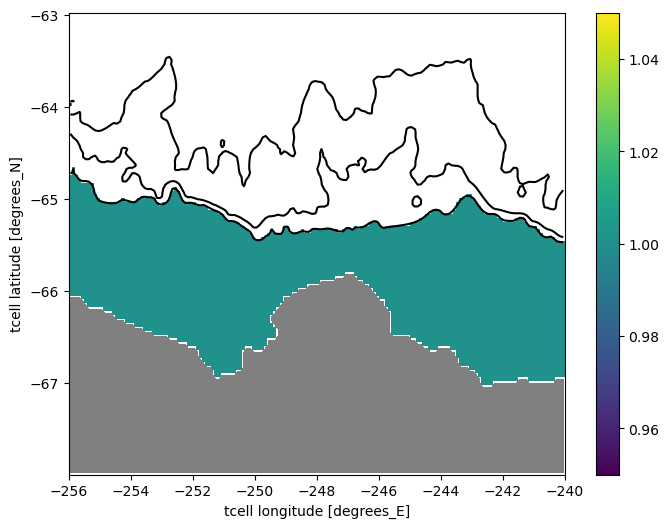

In [68]:
# Mask 
lon_slice  = slice(-256, -240)
lat_slice  = slice(-68,-63)
# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/v45/ns3783/scripts/masks/Fig1_mask1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [70]:
#apply the mask
t_400_on = t_400*region_mask
t_400_on = t_400_on.where(t_400_on!=0)

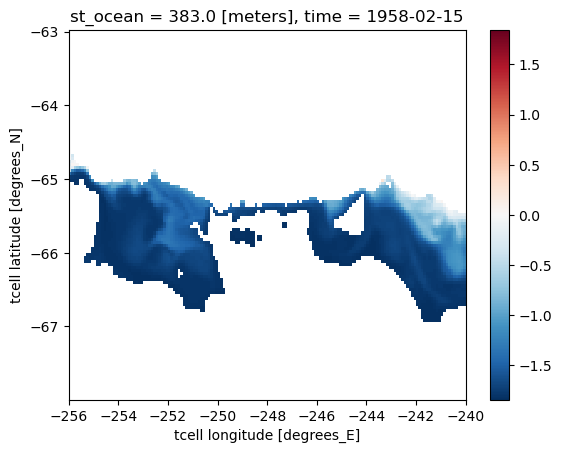

In [73]:
t_400_on[1].plot()

### FIGURE 1 - make sure all looks good before looping through

#### temp_400m everywhere

/jobfs/154769910.gadi-pbs/ipykernel_1129815/927267369.py:22: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


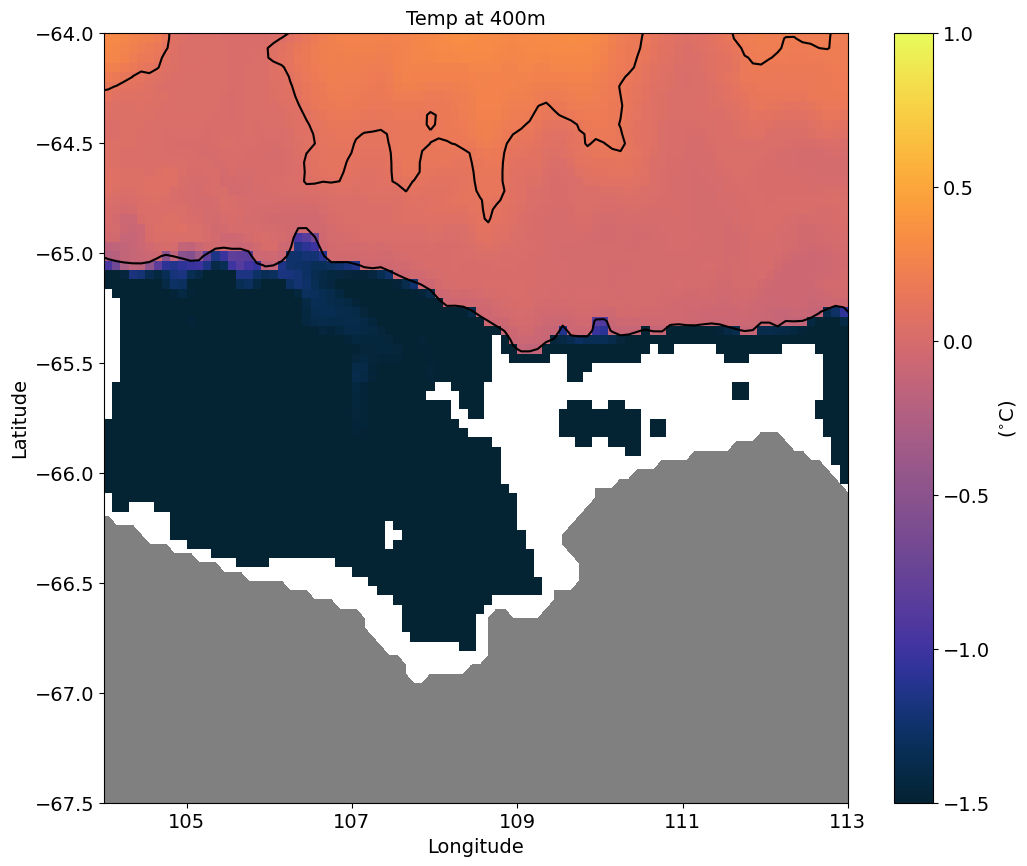

In [88]:
fontsize=14;

fig=plt.figure(figsize=(12,10))

nt = 0
temp_400m_eta = t_400_on.isel(time=nt)
temp_1000m_eta = t_1000.isel(time=nt)
plt.title('Temp at 400m',fontsize=fontsize)
# plot the temperature:
#pc = plt.pcolormesh(t_400.xt_ocean,t_400.yt_ocean,temp_400m_eta, cmap = cmocean.thermal,
#               vmin=-2,vmax=2)
pc = plt.pcolormesh(t_400_on.xt_ocean,t_400_on.yt_ocean,
                        temp_400m_eta, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1)

pc = plt.pcolormesh(t_1000.xt_ocean,t_1000.yt_ocean,
                        temp_1000m_eta, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1)



plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
# labels etc:
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
#lim for Shack + Vincennes Bay
#plt.ylim((-67.5, -63))
#plt.xlim((-275, -245))
plt.ylim((-67.5, -64))
plt.xlim((-255, -246))
#ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
ax = plt.gca()
xticks = [-254, -252, -250, -248, -246]
ax.set_xticks(xticks)
ax.set_xticklabels([x + 359 for x in xticks], fontsize=fontsize)  # if you want converted labels

# colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize = 14,labelpad=5)
cbar.ax.tick_params(labelsize=14)

In [89]:
# Now loop through each time step and save an image, using same plotting code as perfected above:
nframes = len(t_400_on.time)
#nframes=2

fontsize=12
# Define the levels for the contourf
lvls = np.arange(-2.5, 2.6, .05)
norm = col.Normalize(vmin=-2.5,vmax=2.5)

#def updatefig(nt):
for nt in range(0,nframes):
    temp_400m_eta = t_400_on.isel(time=nt).load
    temp_1000m_eta = t_1000.isel(time=nt).load
    mth = str(t_400_on.time[nt].dt.month.data)
    yr = str(t_400_on.time[nt].dt.year.data)

    print('On iteration:', nt, 'month: ',mth, 'year: ',yr)

    plt.figure(figsize=(12,10))
    
    temp_400m_eta = t_400_on.isel(time=nt)
    temp_1000m_eta = t_1000.isel(time=nt)
    plt.title('Temperature at 400m (shelf) and 1000m (offshore) ' + mth + ' ' + yr,fontsize=fontsize)
    
    # plot the temperature:
    pc = plt.pcolormesh(t_400_on.xt_ocean,t_400_on.yt_ocean,temp_400m_eta, cmap = cmocean.thermal,
               vmin=-1.5,vmax=1)
    pc = plt.pcolormesh(t_1000.xt_ocean,t_1000.yt_ocean,
                        temp_1000m_eta, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1)

    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)
    # plot the land:
    plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
    # labels etc:
    plt.xlabel('Longitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.ylabel('Latitude',fontsize=fontsize)
    #lim
    plt.ylim((-67.5, -63))
    plt.xlim((-255, -246))
    # colorbar:
    cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
    cbar.ax.locator_params(nbins=8)
    cbar.set_label(r'($^{\circ}$C)', fontsize = 14,labelpad=5)
    cbar.ax.tick_params(labelsize=14)
    ax = plt.gca()
    xticks = [-254, -252, -250, -248, -246]
    ax.set_xticks(xticks)
    ax.set_xticklabels([x + 359 for x in xticks], fontsize=fontsize)  # if you want converted labels
    
    figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/Temp_video'
    # save frame
    filestr = figdir+'/image%04d.png' % nt
    plt.savefig(filestr,dpi=150,bbox_inches='tight')
    plt.clf()
    #return p1

On iteration: 0 month:  1 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 1 month:  2 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 2 month:  3 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 3 month:  4 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 4 month:  5 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 5 month:  6 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 6 month:  7 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 7 month:  8 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 8 month:  9 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 9 month:  10 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 10 month:  11 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 11 month:  12 year:  1958


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 12 month:  1 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 13 month:  2 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 14 month:  3 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 15 month:  4 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 16 month:  5 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 17 month:  6 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 18 month:  7 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 19 month:  8 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 20 month:  9 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,10))
/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 21 month:  10 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 22 month:  11 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 23 month:  12 year:  1959


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 24 month:  1 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 25 month:  2 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 26 month:  3 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 27 month:  4 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 28 month:  5 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 29 month:  6 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 30 month:  7 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 31 month:  8 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 32 month:  9 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 33 month:  10 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 34 month:  11 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 35 month:  12 year:  1960


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 36 month:  1 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 37 month:  2 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 38 month:  3 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 39 month:  4 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 40 month:  5 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 41 month:  6 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 42 month:  7 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 43 month:  8 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 44 month:  9 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 45 month:  10 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 46 month:  11 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 47 month:  12 year:  1961


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 48 month:  1 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 49 month:  2 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 50 month:  3 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 51 month:  4 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 52 month:  5 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 53 month:  6 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 54 month:  7 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 55 month:  8 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 56 month:  9 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 57 month:  10 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 58 month:  11 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 59 month:  12 year:  1962


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 60 month:  1 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 61 month:  2 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 62 month:  3 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 63 month:  4 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 64 month:  5 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 65 month:  6 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 66 month:  7 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 67 month:  8 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 68 month:  9 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 69 month:  10 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 70 month:  11 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 71 month:  12 year:  1963


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 72 month:  1 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 73 month:  2 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 74 month:  3 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 75 month:  4 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 76 month:  5 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 77 month:  6 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 78 month:  7 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 79 month:  8 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 80 month:  9 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 81 month:  10 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 82 month:  11 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 83 month:  12 year:  1964


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 84 month:  1 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 85 month:  2 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 86 month:  3 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 87 month:  4 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 88 month:  5 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 89 month:  6 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 90 month:  7 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 91 month:  8 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 92 month:  9 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 93 month:  10 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 94 month:  11 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 95 month:  12 year:  1965


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 96 month:  1 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 97 month:  2 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 98 month:  3 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 99 month:  4 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 100 month:  5 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 101 month:  6 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 102 month:  7 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 103 month:  8 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 104 month:  9 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 105 month:  10 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 106 month:  11 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 107 month:  12 year:  1966


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 108 month:  1 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 109 month:  2 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 110 month:  3 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 111 month:  4 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 112 month:  5 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 113 month:  6 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 114 month:  7 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 115 month:  8 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 116 month:  9 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 117 month:  10 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 118 month:  11 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 119 month:  12 year:  1967


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 120 month:  1 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 121 month:  2 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 122 month:  3 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 123 month:  4 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 124 month:  5 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 125 month:  6 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 126 month:  7 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 127 month:  8 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 128 month:  9 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 129 month:  10 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 130 month:  11 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 131 month:  12 year:  1968


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 132 month:  1 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 133 month:  2 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 134 month:  3 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 135 month:  4 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 136 month:  5 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 137 month:  6 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 138 month:  7 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 139 month:  8 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 140 month:  9 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 141 month:  10 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 142 month:  11 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 143 month:  12 year:  1969


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 144 month:  1 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 145 month:  2 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 146 month:  3 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 147 month:  4 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 148 month:  5 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 149 month:  6 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 150 month:  7 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 151 month:  8 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 152 month:  9 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 153 month:  10 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 154 month:  11 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 155 month:  12 year:  1970


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 156 month:  1 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 157 month:  2 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 158 month:  3 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 159 month:  4 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 160 month:  5 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 161 month:  6 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 162 month:  7 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 163 month:  8 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 164 month:  9 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 165 month:  10 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 166 month:  11 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 167 month:  12 year:  1971


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 168 month:  1 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 169 month:  2 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 170 month:  3 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 171 month:  4 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 172 month:  5 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 173 month:  6 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 174 month:  7 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 175 month:  8 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 176 month:  9 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 177 month:  10 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 178 month:  11 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 179 month:  12 year:  1972


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 180 month:  1 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 181 month:  2 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 182 month:  3 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 183 month:  4 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 184 month:  5 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 185 month:  6 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 186 month:  7 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 187 month:  8 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 188 month:  9 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 189 month:  10 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 190 month:  11 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 191 month:  12 year:  1973


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 192 month:  1 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 193 month:  2 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 194 month:  3 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 195 month:  4 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 196 month:  5 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 197 month:  6 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 198 month:  7 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 199 month:  8 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 200 month:  9 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 201 month:  10 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 202 month:  11 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 203 month:  12 year:  1974


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 204 month:  1 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 205 month:  2 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 206 month:  3 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 207 month:  4 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 208 month:  5 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 209 month:  6 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 210 month:  7 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 211 month:  8 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 212 month:  9 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 213 month:  10 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 214 month:  11 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 215 month:  12 year:  1975


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 216 month:  1 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 217 month:  2 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 218 month:  3 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 219 month:  4 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 220 month:  5 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 221 month:  6 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 222 month:  7 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 223 month:  8 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 224 month:  9 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 225 month:  10 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 226 month:  11 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 227 month:  12 year:  1976


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 228 month:  1 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 229 month:  2 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 230 month:  3 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 231 month:  4 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 232 month:  5 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 233 month:  6 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 234 month:  7 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 235 month:  8 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 236 month:  9 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 237 month:  10 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 238 month:  11 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 239 month:  12 year:  1977


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 240 month:  1 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 241 month:  2 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 242 month:  3 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 243 month:  4 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 244 month:  5 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 245 month:  6 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 246 month:  7 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 247 month:  8 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 248 month:  9 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 249 month:  10 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 250 month:  11 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 251 month:  12 year:  1978


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 252 month:  1 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 253 month:  2 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 254 month:  3 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 255 month:  4 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 256 month:  5 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 257 month:  6 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 258 month:  7 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 259 month:  8 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 260 month:  9 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 261 month:  10 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 262 month:  11 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 263 month:  12 year:  1979


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 264 month:  1 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 265 month:  2 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 266 month:  3 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 267 month:  4 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 268 month:  5 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 269 month:  6 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 270 month:  7 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 271 month:  8 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 272 month:  9 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 273 month:  10 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 274 month:  11 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 275 month:  12 year:  1980


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 276 month:  1 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 277 month:  2 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 278 month:  3 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 279 month:  4 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 280 month:  5 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 281 month:  6 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 282 month:  7 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 283 month:  8 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 284 month:  9 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 285 month:  10 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 286 month:  11 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 287 month:  12 year:  1981


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 288 month:  1 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 289 month:  2 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 290 month:  3 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 291 month:  4 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 292 month:  5 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 293 month:  6 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 294 month:  7 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 295 month:  8 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 296 month:  9 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 297 month:  10 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 298 month:  11 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 299 month:  12 year:  1982


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 300 month:  1 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 301 month:  2 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 302 month:  3 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 303 month:  4 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 304 month:  5 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 305 month:  6 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 306 month:  7 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 307 month:  8 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 308 month:  9 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 309 month:  10 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 310 month:  11 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 311 month:  12 year:  1983


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 312 month:  1 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 313 month:  2 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 314 month:  3 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 315 month:  4 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 316 month:  5 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 317 month:  6 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 318 month:  7 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 319 month:  8 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 320 month:  9 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 321 month:  10 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 322 month:  11 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 323 month:  12 year:  1984


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 324 month:  1 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 325 month:  2 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 326 month:  3 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 327 month:  4 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 328 month:  5 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 329 month:  6 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 330 month:  7 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 331 month:  8 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 332 month:  9 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 333 month:  10 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 334 month:  11 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 335 month:  12 year:  1985


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 336 month:  1 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 337 month:  2 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 338 month:  3 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 339 month:  4 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 340 month:  5 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 341 month:  6 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 342 month:  7 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 343 month:  8 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 344 month:  9 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 345 month:  10 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 346 month:  11 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 347 month:  12 year:  1986


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 348 month:  1 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 349 month:  2 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 350 month:  3 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 351 month:  4 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 352 month:  5 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 353 month:  6 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 354 month:  7 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 355 month:  8 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 356 month:  9 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 357 month:  10 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 358 month:  11 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 359 month:  12 year:  1987


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 360 month:  1 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 361 month:  2 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 362 month:  3 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 363 month:  4 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 364 month:  5 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 365 month:  6 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 366 month:  7 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 367 month:  8 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 368 month:  9 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 369 month:  10 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 370 month:  11 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 371 month:  12 year:  1988


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 372 month:  1 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 373 month:  2 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 374 month:  3 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 375 month:  4 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 376 month:  5 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 377 month:  6 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 378 month:  7 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 379 month:  8 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 380 month:  9 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 381 month:  10 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 382 month:  11 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 383 month:  12 year:  1989


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 384 month:  1 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 385 month:  2 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 386 month:  3 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 387 month:  4 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 388 month:  5 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 389 month:  6 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 390 month:  7 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 391 month:  8 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 392 month:  9 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 393 month:  10 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 394 month:  11 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 395 month:  12 year:  1990


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 396 month:  1 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 397 month:  2 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 398 month:  3 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 399 month:  4 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 400 month:  5 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 401 month:  6 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 402 month:  7 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 403 month:  8 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 404 month:  9 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 405 month:  10 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 406 month:  11 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 407 month:  12 year:  1991


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 408 month:  1 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 409 month:  2 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 410 month:  3 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 411 month:  4 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 412 month:  5 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 413 month:  6 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 414 month:  7 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 415 month:  8 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 416 month:  9 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 417 month:  10 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 418 month:  11 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 419 month:  12 year:  1992


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 420 month:  1 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 421 month:  2 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 422 month:  3 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 423 month:  4 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 424 month:  5 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 425 month:  6 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 426 month:  7 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 427 month:  8 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 428 month:  9 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 429 month:  10 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 430 month:  11 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 431 month:  12 year:  1993


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 432 month:  1 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 433 month:  2 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 434 month:  3 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 435 month:  4 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 436 month:  5 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 437 month:  6 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 438 month:  7 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 439 month:  8 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 440 month:  9 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 441 month:  10 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 442 month:  11 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 443 month:  12 year:  1994


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 444 month:  1 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 445 month:  2 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 446 month:  3 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 447 month:  4 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 448 month:  5 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 449 month:  6 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 450 month:  7 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 451 month:  8 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 452 month:  9 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 453 month:  10 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 454 month:  11 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 455 month:  12 year:  1995


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 456 month:  1 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 457 month:  2 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 458 month:  3 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 459 month:  4 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 460 month:  5 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 461 month:  6 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 462 month:  7 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 463 month:  8 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 464 month:  9 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 465 month:  10 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 466 month:  11 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 467 month:  12 year:  1996


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 468 month:  1 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 469 month:  2 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 470 month:  3 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 471 month:  4 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 472 month:  5 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 473 month:  6 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 474 month:  7 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 475 month:  8 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 476 month:  9 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 477 month:  10 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 478 month:  11 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 479 month:  12 year:  1997


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 480 month:  1 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 481 month:  2 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 482 month:  3 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 483 month:  4 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 484 month:  5 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 485 month:  6 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 486 month:  7 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 487 month:  8 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 488 month:  9 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 489 month:  10 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 490 month:  11 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 491 month:  12 year:  1998


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 492 month:  1 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 493 month:  2 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 494 month:  3 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 495 month:  4 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 496 month:  5 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 497 month:  6 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 498 month:  7 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 499 month:  8 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 500 month:  9 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 501 month:  10 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 502 month:  11 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 503 month:  12 year:  1999


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 504 month:  1 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 505 month:  2 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 506 month:  3 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 507 month:  4 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 508 month:  5 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 509 month:  6 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 510 month:  7 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 511 month:  8 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 512 month:  9 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 513 month:  10 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 514 month:  11 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 515 month:  12 year:  2000


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 516 month:  1 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 517 month:  2 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 518 month:  3 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 519 month:  4 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 520 month:  5 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 521 month:  6 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 522 month:  7 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 523 month:  8 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 524 month:  9 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 525 month:  10 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 526 month:  11 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 527 month:  12 year:  2001


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 528 month:  1 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 529 month:  2 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 530 month:  3 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 531 month:  4 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 532 month:  5 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 533 month:  6 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 534 month:  7 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 535 month:  8 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 536 month:  9 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 537 month:  10 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 538 month:  11 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 539 month:  12 year:  2002


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 540 month:  1 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 541 month:  2 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 542 month:  3 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 543 month:  4 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 544 month:  5 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 545 month:  6 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 546 month:  7 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 547 month:  8 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 548 month:  9 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 549 month:  10 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 550 month:  11 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 551 month:  12 year:  2003


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 552 month:  1 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 553 month:  2 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 554 month:  3 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 555 month:  4 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 556 month:  5 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 557 month:  6 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 558 month:  7 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 559 month:  8 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 560 month:  9 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 561 month:  10 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 562 month:  11 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 563 month:  12 year:  2004


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 564 month:  1 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 565 month:  2 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 566 month:  3 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 567 month:  4 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 568 month:  5 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 569 month:  6 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 570 month:  7 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 571 month:  8 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 572 month:  9 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 573 month:  10 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 574 month:  11 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 575 month:  12 year:  2005


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 576 month:  1 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 577 month:  2 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 578 month:  3 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 579 month:  4 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 580 month:  5 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 581 month:  6 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 582 month:  7 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 583 month:  8 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 584 month:  9 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 585 month:  10 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 586 month:  11 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 587 month:  12 year:  2006


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 588 month:  1 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 589 month:  2 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 590 month:  3 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 591 month:  4 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 592 month:  5 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 593 month:  6 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 594 month:  7 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 595 month:  8 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 596 month:  9 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 597 month:  10 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 598 month:  11 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 599 month:  12 year:  2007


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 600 month:  1 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 601 month:  2 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 602 month:  3 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 603 month:  4 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 604 month:  5 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 605 month:  6 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 606 month:  7 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 607 month:  8 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 608 month:  9 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 609 month:  10 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 610 month:  11 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 611 month:  12 year:  2008


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 612 month:  1 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 613 month:  2 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 614 month:  3 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 615 month:  4 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 616 month:  5 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 617 month:  6 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 618 month:  7 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 619 month:  8 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 620 month:  9 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 621 month:  10 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 622 month:  11 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 623 month:  12 year:  2009


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 624 month:  1 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 625 month:  2 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 626 month:  3 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 627 month:  4 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 628 month:  5 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 629 month:  6 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 630 month:  7 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 631 month:  8 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 632 month:  9 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 633 month:  10 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 634 month:  11 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 635 month:  12 year:  2010


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 636 month:  1 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 637 month:  2 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 638 month:  3 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 639 month:  4 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 640 month:  5 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 641 month:  6 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 642 month:  7 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 643 month:  8 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 644 month:  9 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 645 month:  10 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 646 month:  11 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 647 month:  12 year:  2011


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 648 month:  1 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 649 month:  2 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 650 month:  3 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 651 month:  4 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 652 month:  5 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 653 month:  6 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 654 month:  7 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 655 month:  8 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 656 month:  9 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 657 month:  10 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 658 month:  11 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 659 month:  12 year:  2012


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 660 month:  1 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 661 month:  2 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 662 month:  3 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 663 month:  4 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 664 month:  5 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 665 month:  6 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 666 month:  7 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 667 month:  8 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 668 month:  9 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 669 month:  10 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 670 month:  11 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 671 month:  12 year:  2013


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 672 month:  1 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 673 month:  2 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 674 month:  3 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 675 month:  4 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 676 month:  5 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 677 month:  6 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 678 month:  7 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 679 month:  8 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 680 month:  9 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 681 month:  10 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 682 month:  11 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 683 month:  12 year:  2014


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 684 month:  1 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 685 month:  2 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 686 month:  3 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 687 month:  4 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 688 month:  5 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 689 month:  6 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 690 month:  7 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 691 month:  8 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 692 month:  9 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 693 month:  10 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 694 month:  11 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 695 month:  12 year:  2015


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 696 month:  1 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 697 month:  2 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 698 month:  3 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 699 month:  4 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 700 month:  5 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 701 month:  6 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 702 month:  7 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 703 month:  8 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 704 month:  9 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 705 month:  10 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 706 month:  11 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 707 month:  12 year:  2016


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 708 month:  1 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 709 month:  2 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 710 month:  3 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 711 month:  4 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 712 month:  5 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 713 month:  6 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 714 month:  7 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 715 month:  8 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 716 month:  9 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 717 month:  10 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 718 month:  11 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 719 month:  12 year:  2017


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 720 month:  1 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 721 month:  2 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 722 month:  3 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 723 month:  4 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 724 month:  5 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 725 month:  6 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 726 month:  7 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 727 month:  8 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 728 month:  9 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 729 month:  10 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 730 month:  11 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


On iteration: 731 month:  12 year:  2018


/jobfs/154769910.gadi-pbs/ipykernel_1129815/2869250433.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)


<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [90]:
# Code to make the movie from the frames
os.chdir(figdir)
!ffmpeg -y -framerate 4 -pattern_type glob -i '/g/data/v45/ns3783/ScriptsChapter3/Figures/Temp_video/image*.png' -s 1800x1020 -c:v libx264 -pix_fmt yuv420p 'temp_400m.mp4'

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/g/data/xp65/public/./apps/med_conda/envs/analysis3-25.10 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --ena

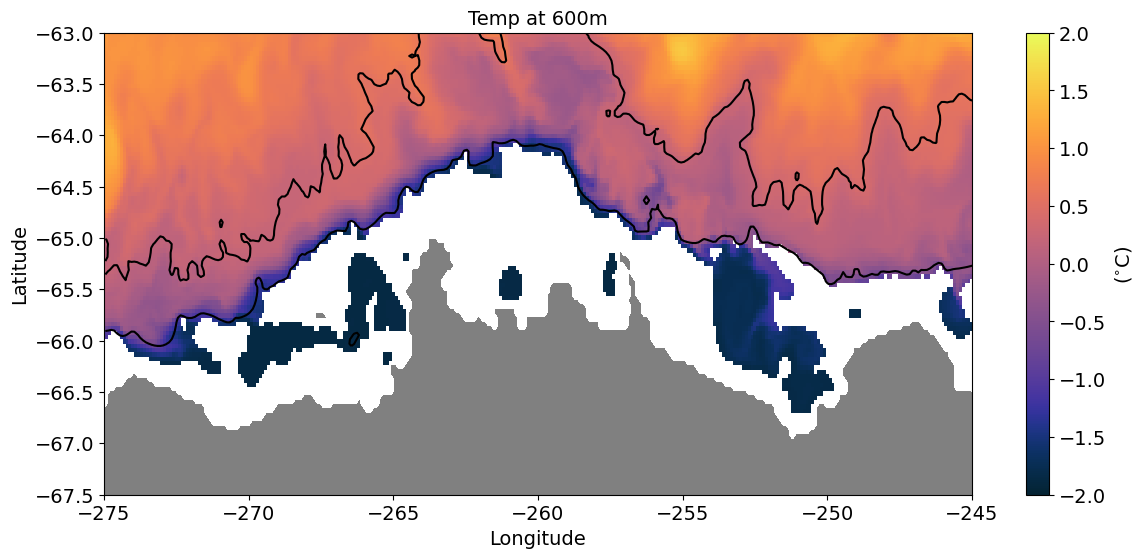

In [6]:
#temp at 600m
fontsize=14;

plt.figure(figsize=(14,6))

nt = 0
temp_600m_eta = temp_600m.isel(time=nt)
plt.title('Temp at 600m',fontsize=fontsize)
# plot the temperature:
pc = plt.pcolormesh(temp_600m.xt_ocean,temp_600m.yt_ocean,temp_600m_eta, cmap = cmocean.thermal,
               vmin=-2,vmax=2)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
# labels etc:
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#lim
plt.ylim((-67.5, -63))
plt.xlim((-275, -245))
# colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize = 14,labelpad=5)
cbar.ax.tick_params(labelsize=14)

In [9]:
# Now loop through each time step and save an image, using same plotting code as perfected above:
nframes = len(temp_600m.time)
#nframes=2

fontsize=12
# Define the levels for the contourf
lvls = np.arange(-2.5, 2.6, .05)
norm = col.Normalize(vmin=-2.5,vmax=2.5)

#def updatefig(nt):
for nt in range(0,nframes):
    temp_600m_eta = temp_600m.isel(time=nt).load
    mth = str(temp_600m.time[nt].dt.month.data)
    yr = str(temp_600m.time[nt].dt.year.data)

    print('On iteration:', nt, 'month: ',mth, 'year: ',yr)

    plt.figure(figsize=(14,6))
    
    temp_600m_eta = temp_600m.isel(time=nt)
    plt.title('T 600m ' + mth + ' ' + yr,fontsize=fontsize)
    
    # plot the temperature:
    pc = plt.pcolormesh(temp_600m.xt_ocean,temp_600m.yt_ocean,temp_600m_eta, cmap = cmocean.thermal,
               vmin=-2,vmax=2)

    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=.5)
    # plot the land:
    plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
    # labels etc:
    plt.xlabel('Longitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.ylabel('Latitude',fontsize=fontsize)
    #lim
    plt.ylim((-67.5, -63))
    plt.xlim((-275, -245))
    # colorbar:
    cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
    cbar.ax.locator_params(nbins=8)
    cbar.set_label(r'($^{\circ}$C)', fontsize = 14,labelpad=5)
    cbar.ax.tick_params(labelsize=14)
    
    figdir = '/g/data/x77/ns3783/4th_round_analysis/'
    # save frame
    filestr = figdir+'/frames2/image%04d.png' % nt
    plt.savefig(filestr,dpi=150,bbox_inches='tight')
    plt.clf()
    #return p1

On iteration: 0 month:  1 year:  1958
On iteration: 1 month:  2 year:  1958
On iteration: 2 month:  3 year:  1958
On iteration: 3 month:  4 year:  1958
On iteration: 4 month:  5 year:  1958
On iteration: 5 month:  6 year:  1958
On iteration: 6 month:  7 year:  1958
On iteration: 7 month:  8 year:  1958
On iteration: 8 month:  9 year:  1958
On iteration: 9 month:  10 year:  1958
On iteration: 10 month:  11 year:  1958
On iteration: 11 month:  12 year:  1958
On iteration: 12 month:  1 year:  1959
On iteration: 13 month:  2 year:  1959
On iteration: 14 month:  3 year:  1959
On iteration: 15 month:  4 year:  1959
On iteration: 16 month:  5 year:  1959
On iteration: 17 month:  6 year:  1959
On iteration: 18 month:  7 year:  1959
On iteration: 19 month:  8 year:  1959
On iteration: 20 month:  9 year:  1959
On iteration: 21 month:  10 year:  1959
On iteration: 22 month:  11 year:  1959
On iteration: 23 month:  12 year:  1959
On iteration: 24 month:  1 year:  1960
On iteration: 25 month:  2 ye

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [4]:
# Code to make the movie from the frames
figdir = '/g/data/x77/ns3783/4th_round_analysis/'
os.chdir(figdir)
!ffmpeg -y -framerate 4 -pattern_type glob -i '/g/data/x77/ns3783/4th_round_analysis/frames2/image*.png' -s 1800x1020 -c:v libx264 -pix_fmt yuv420p 'temp_600m.mp4'

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavforma

OTHER CODE OPTION

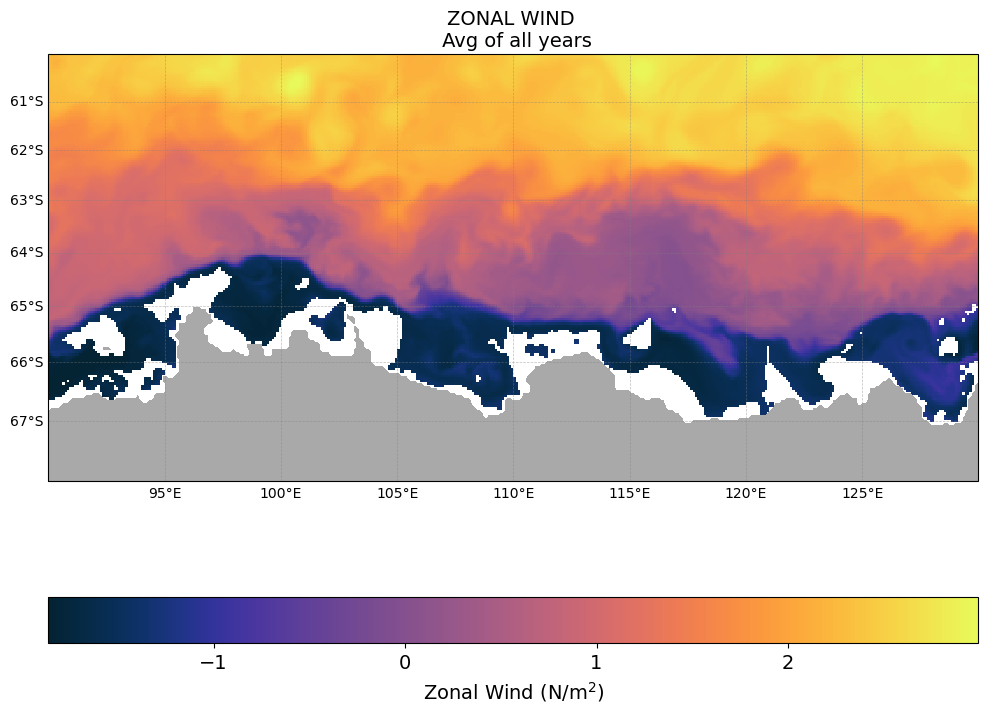

In [52]:
fontsize=14;
projection=ccrs.Mercator(central_longitude=-259.15)
plt.figure(figsize=(12,10))

nt = 700
temp_400m_eta = temp_400m.isel(time=nt)
ax = plt.axes(projection=projection)

ax.set_extent([90, 130, -68, -60], crs=ccrs.PlateCarree())
plt.title('ZONAL WIND \n Avg of all years',fontsize=fontsize)
plot = ax.pcolormesh(temp_400m.xt_ocean,temp_400m.yt_ocean,temp_400m_eta,
                     cmap = cmocean.thermal,transform = ccrs.PlateCarree())
#pc=plt.pcolormesh(tau_x_con_avg.xu_ocean,tau_x_con_avg.yu_ocean,tau_x_con_avg,cmap=cmocean.curl,vmin=-8,vmax=8)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#plt.ylim((-68, -60)) 
#plt.xlim((-255.9, -245.4)) 
# plot land:
ax.contourf(ht.xt_ocean,land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean, ht.yt_ocean,land_mask,[0,1], colors = 'k', linewidths = .5, 
           transform=ccrs.PlateCarree())
# colorbar:
cbar=plt.colorbar(plot,orientation='horizontal',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Zonal Wind (N/m$^{2}$)', fontsize = 14,labelpad=5)
cbar.ax.tick_params(labelsize=14)

In [64]:
## trying to work on cartopy.

In [51]:
land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

TypeError: Axes.hist() got multiple values for argument 'x'

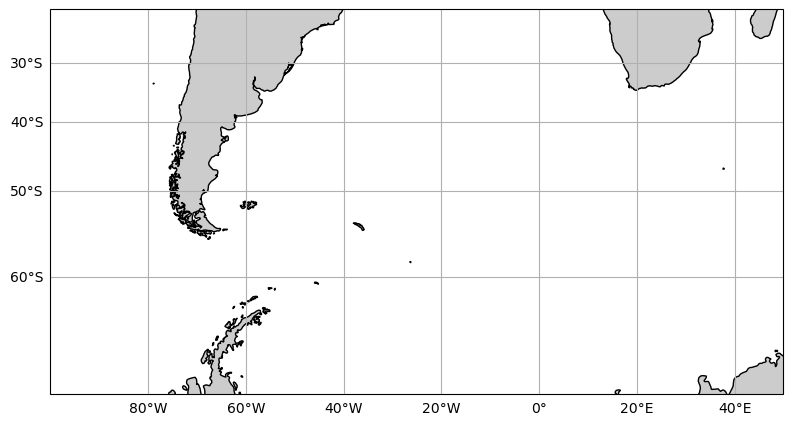

In [54]:
projection = ccrs.Mercator(
    central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0
)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([-255, -252, -249, -246], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")
ax.gridlines(draw_labels={"bottom": True, "left": True, "top": False, "right": False})

t_400.plot(
    x="yt_ocean",
    y="xt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);
